텐서 단계가 아니라 이미지 단위에서 변환과, keypoint 변환이 함께 가동되어야 함

---

In [1]:
%load_ext lab_black

In [2]:
import math
import os
import random
import shutil
import json
import logging
import sys
from collections import defaultdict
from datetime import datetime
from io import TextIOWrapper
from pathlib import Path
from typing import Callable, List, Sequence, Tuple

import albumentations as A
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.tensorboard import SummaryWriter
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from tqdm import tqdm
from PIL import Image

import utils
import networks

In [3]:
train_imgs = np.array(sorted(list(Path("data/box_effdet2/train_imgs/").glob("*.jpg"))))
test_imgs = np.array(sorted(list(Path("data/box_effdet2/test_imgs/").glob("*.jpg"))))

In [4]:
df = pd.read_csv("data/box_effdet2/train_df.csv")
keypoints = df.to_numpy()[:, 1:].astype(np.float32)
keypoints = np.stack([keypoints[:, 0::2], keypoints[:, 1::2]], axis=2)

In [5]:
with open("data/box_effdet2/offset.json", "r") as f:
    offsets = json.load(f)

In [6]:
x = imageio.imread(train_imgs[0])
k = keypoints[0]
offset = offsets["train"][0]["boxes"]
ratio = offsets["train"][0]["ratio"]

In [7]:
offset, ratio

([806, 258], 1.1962616822429906)

In [8]:
k[:, 0] -= offset[0]
k[:, 1] -= offset[1]
k *= ratio

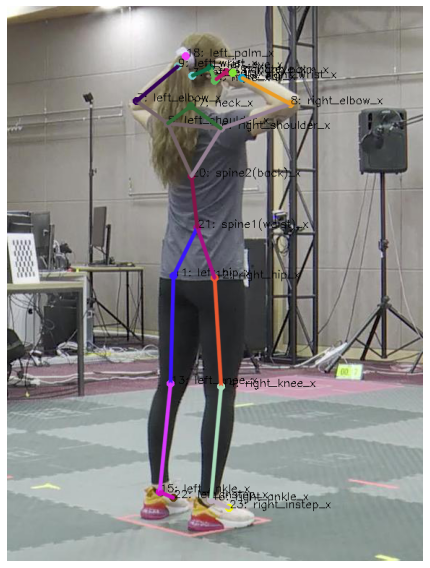

In [9]:
utils.draw_keypoints_show(x, k)

---

## Horizontal Flip

In [12]:
class HorizontalFlip:
    def __init__(self, p=0.5):
        columns = "nose_x;nose_y;left_eye_x;left_eye_y;right_eye_x;right_eye_y;left_ear_x;left_ear_y;right_ear_x;right_ear_y;left_shoulder_x;left_shoulder_y;right_shoulder_x;right_shoulder_y;left_elbow_x;left_elbow_y;right_elbow_x;right_elbow_y;left_wrist_x;left_wrist_y;right_wrist_x;right_wrist_y;left_hip_x;left_hip_y;right_hip_x;right_hip_y;left_knee_x;left_knee_y;right_knee_x;right_knee_y;left_ankle_x;left_ankle_y;right_ankle_x;right_ankle_y;neck_x;neck_y;left_palm_x;left_palm_y;right_palm_x;right_palm_y;spine2(back)_x;spine2(back)_y;spine1(waist)_x;spine1(waist)_y;left_instep_x;left_instep_y;right_instep_x;right_instep_y"
        columns = columns.split(";")
        c2i = {c: i for i, c in enumerate(df.columns[1:])}
        self.swap_columns = []
        for i, c in enumerate(df.columns[1:]):
            if c.startswith("left_") and c.endswith("_x"):
                self.swap_columns.append((i // 2, c2i["right_" + c[5:]] // 2))

        self.p = p

    def __call__(self, x, keypoints):
        if random.random() > self.p:
            return x, keypoints

        x = np.fliplr(x).copy()
        k = keypoints.copy()
        maxw = x.shape[1]
        k[:, 0] = maxw - k[:, 0]
        for a, b in self.swap_columns:
            temp = k[a].copy()
            k[a] = k[b].copy()
            k[b] = temp

        return x, k

In [13]:
horizontal_flip = HorizontalFlip(p=1)

In [14]:
x_, k_ = horizontal_flip(x, k)

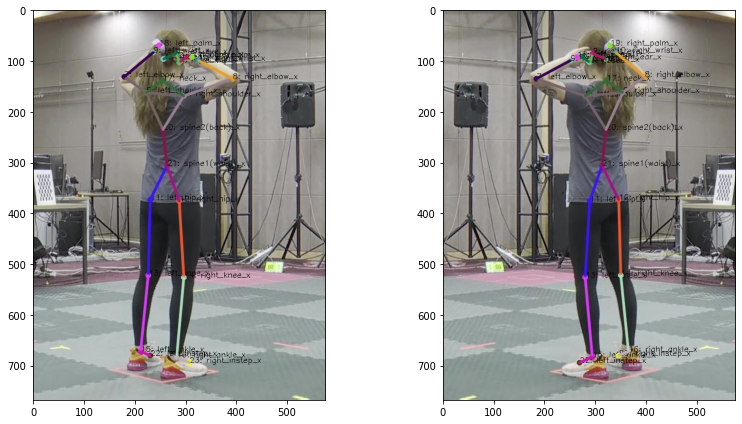

In [18]:
utils.imshow_horizon(utils.draw_keypoints(x, k), utils.draw_keypoints(x_, k_))

---

## Random Shift

In [18]:
x = ds_test[0][1]

In [19]:
xp = 20
yp = -20

In [20]:
dx = torch.zeros_like(x)

In [21]:
_, H, W = dx.shape

In [22]:
dxl = xp if xp >= 0 else 0
dxr = W if xp >= 0 else W + xp
dxt = yp if yp >= 0 else 0
dxb = H if yp >= 0 else H + yp
xl = 0 if xp >= 0 else -xp
xr = W - xp if xp >= 0 else W
xt = 0 if yp >= 0 else -yp
xb = H - yp if yp >= 0 else H

In [23]:
dxl, dxr, dxt, dxb

(20, 576, 0, 748)

In [24]:
xl, xr, xt, xb

(0, 556, 20, 768)

In [25]:
dx[..., dxt:dxb, dxl:dxr] = x[..., xt:xb, xl:xr]

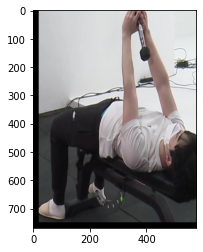

In [26]:
plt.imshow(dx.permute(1, 2, 0))

In [ ]:
xmin, xmax, ymin, ymax = 9999, 0, 9999, 0
for *_, y in tqdm(ds_train_total, ncols=100):
    nums = utils.nums2keypoints(y)
    xmin = min(xmin, nums[:, 0].min())
    xmax = max(xmax, nums[:, 0].max())
    ymin = min(ymin, nums[:, 1].min())
    ymax = max(ymax, nums[:, 1].max())

In [ ]:
xmin, xmax, ymin, ymax

In [ ]:
576 / 4, 768 / 4

좌2, 우6, 상8, 하6

그러므로 x는 -2-6, y는 -8-6만 가능

---

## Rotate90

이미지 회전이 의미가 있을지 모르겠는데...  
테스트셋에 유독 누워있는 이미지가 많기 때문에 rotate도 나쁘지는 않을거같기도 하고?  
하지만 이미지 가로세로 사이즈 맞추는건 해줘야하나?

TODO